In [1]:
import os
import tensorflow as tf

from modules.run import load_config
from modules.run import Trainer
from modules.data import DataManager
from modules.models import pretrained_cnn, pretrained_cnn_multichannel

## Testing imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
config=load_config("cls_cropped_Xception_all")
data_manager = DataManager(config)


train_generator, val_generator, dataframe = data_manager.generate_kenya()
convnet = pretrained_cnn_multichannel(config, image_size=config["image_size"], n_channels=config["n_channels"])
trainer = Trainer(config)

Declouded dataframe length: 152505
Found 135000 validated image filenames belonging to 3 classes.
Found 15000 validated image filenames belonging to 3 classes.
83689472/83683744 [==============================] - 13s 0us/step


In [3]:
convnet.compile(loss=trainer.loss, optimizer=trainer.optimizer, weighted_metrics=config["weighted_metrics"])

convnet.fit_generator(
    train_generator, 
    epochs=config["n_epochs"],
    callbacks=trainer.callbacks,
    validation_data=val_generator, 
    validation_steps=len(val_generator),
    class_weight=data_manager.class_weight("kenya"),
    use_multiprocessing=True
)

Epoch 1/15
4219/4219 [==============================] - 4051s 960ms/step - loss: 0.5365 - accuracy: 0.7514 - val_loss: 0.4608 - val_accuracy: 0.7922
Epoch 2/15
4219/4219 [==============================] - 1717s 407ms/step - loss: 0.4089 - accuracy: 0.8212 - val_loss: 0.4579 - val_accuracy: 0.7993
Epoch 3/15
4219/4219 [==============================] - 1715s 407ms/step - loss: 0.2642 - accuracy: 0.8899 - val_loss: 0.5158 - val_accuracy: 0.7912
Epoch 4/15
4219/4219 [==============================] - 1718s 407ms/step - loss: 0.1471 - accuracy: 0.9423 - val_loss: 0.6492 - val_accuracy: 0.7932
Epoch 5/15
4219/4219 [==============================] - 1723s 408ms/step - loss: 0.1056 - accuracy: 0.9597 - val_loss: 0.8165 - val_accuracy: 0.7789
Epoch 6/15
4219/4219 [==============================] - 1719s 408ms/step - loss: 0.0856 - accuracy: 0.9671 - val_loss: 0.8035 - val_accuracy: 0.7933
Epoch 7/15
4219/4219 [==============================] - 1714s 406ms/step - loss: 0.0745 - accuracy: 0.9719

In [4]:
predictions = convnet.predict_generator(val_generator, steps=len(val_generator))
predictions = np.argmax(predictions, axis=1)

1073


(2.5, -0.5)

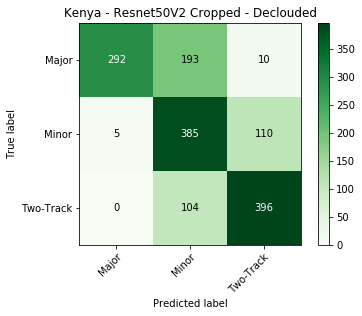

In [8]:
from sklearn.metrics import confusion_matrix

major_indices = [i for i, x in enumerate(val_generator.classes) if x == 0][:500]
minor_indices = [i for i, x in enumerate(val_generator.classes) if x == 1][:500]
two_indices = [i for i, x in enumerate(val_generator.classes) if x == 2][:500]

y_pred = []
y_true = []

for index in major_indices:
    y_true.append(val_generator.classes[index])
    y_pred.append(predictions[index])
    
for index in minor_indices:
    y_true.append(val_generator.classes[index])
    y_pred.append(predictions[index])
    
for index in two_indices:
    y_true.append(val_generator.classes[index])
    y_pred.append(predictions[index])

# y_pred = np.argmax(predictions, axis=1)

print(np.sum(np.array(y_true) == np.array(y_pred)))

classes = ['Major', 'Minor', 'Two-Track']

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Kenya - Resnet50V2 Cropped - Declouded',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
fig.show()
plt.ylim([2.5, -0.5])